### Test the trained network

In [1]:
from keras.layers import Input, Dense, Activation, Lambda, Dropout, Concatenate, Reshape
from keras.models import Model, Sequential
from keras.callbacks import TensorBoard, Callback
from keras import optimizers
from keras import backend as K

import tensorflow as tf

from keras.regularizers import l2


### Hyperparameters
batch_size = 1 
k = 4
d = 3


/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


- Network to load

In [2]:
timestamp = "2018-05-30_02:19"

epoch = 200

- Load gmm params

In [3]:
import numpy as np

In [4]:
filename=timestamp + "-gmmParams.npz"

with np.load(filename) as data:
    phi = data["phi"]
    mu = data["mu"]
    sigma = data["sigma"]
    

In [5]:
phi = K.constant(phi)
mu = K.constant(mu)
sigma = K.constant(sigma)

In [6]:
K.eval(phi)

array([0.25, 0.25, 0.25, 0.25], dtype=float32)

In [7]:
K.eval(mu)

array([[0.83827037, 0.83827037, 0.83827037],
       [0.83827037, 0.83827037, 0.83827037],
       [0.83827037, 0.83827037, 0.83827037],
       [0.83827037, 0.83827037, 0.83827037]], dtype=float32)

In [8]:
K.eval(sigma)

array([[[ 1.1134834 , -0.16407748,  0.8257783 ],
        [-0.16407748,  0.02514663, -0.12420237],
        [ 0.8257783 , -0.12420237,  0.6192002 ]],

       [[ 1.1134834 , -0.16407748,  0.8257783 ],
        [-0.16407748,  0.02514663, -0.12420237],
        [ 0.8257783 , -0.12420237,  0.6192002 ]],

       [[ 1.1134834 , -0.16407748,  0.8257783 ],
        [-0.16407748,  0.02514663, -0.12420237],
        [ 0.8257783 , -0.12420237,  0.6192002 ]],

       [[ 1.1134834 , -0.16407748,  0.8257783 ],
        [-0.16407748,  0.02514663, -0.12420237],
        [ 0.8257783 , -0.12420237,  0.6192002 ]]], dtype=float32)

- Plot loss history

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

In [10]:
from pylab import rcParams
rcParams['figure.figsize'] = 12, 8

In [11]:
def plotHistory(loss_array, save=False, savename=timestamp+"-lossGraph.png"):
    fig = plt.figure()
    ax = fig.add_subplot(111)    # The big subplot
    ax.set_title("Loss graph for end-to-end training")

    ax.set_xlabel('epochs')
    ax.set_ylabel('loss')
    ax.plot(loss_array)
    
    if save:
        plt.savefig(savename)

In [12]:
filename = timestamp + "-history.npz"
with np.load(filename) as data:
    history = data["history"]

history = history.ravel()[0]["loss"]

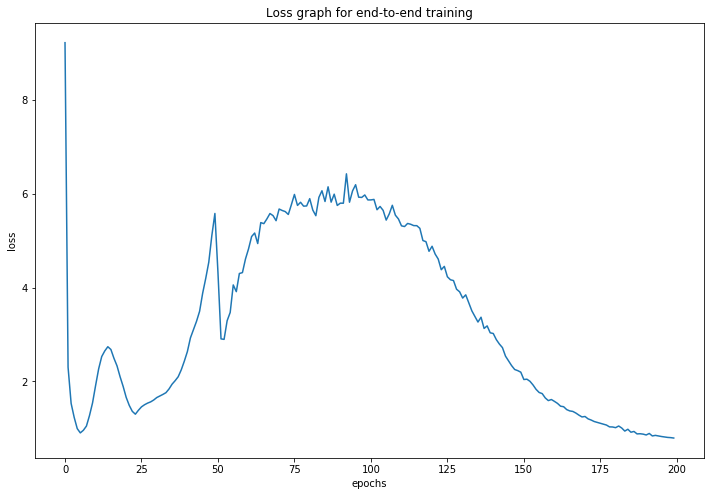

In [13]:
plotHistory(history, save=True)

- Network definition for testing

In [14]:
### Define compresion network

input_data = Input(batch_shape=(batch_size,120), name='input_placeholder')

encoded = Dense(60, activation='tanh', kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001))(input_data)
encoded = Dense(30, activation='tanh', kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001))(encoded)
encoded = Dense(10, activation='tanh', kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001))(encoded)

layer_lowdim = Dense(1, activation='linear', kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001), name='lowdim')(encoded)

decoded = Dense(10, activation='tanh', kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001))(layer_lowdim)
decoded = Dense(30, activation='tanh', kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001))(decoded)
decoded = Dense(60, activation='tanh', kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001))(decoded)
decoded = Dense(120, activation='linear', kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001), name='reconstructed')(decoded)



### Define similarity metrics

def cos_sim(a_b):
    '''
    a: batch x 120
    b: batch x 120 
    
    output: batch x 1
    '''
    a, b = a_b
    
    norm_a = K.sqrt(K.sum(a ** 2, axis=-1))
    norm_b = K.sqrt(K.sum(b ** 2, axis=-1))
    
    out = K.sum(a * b, axis=-1) / (norm_a * norm_b)
    out = K.reshape(out, [batch_size, 1])
    
    return out

def relative_euc_dist(a_b):
    '''
    a: batch x 120
    b: batch x 120 
    
    output: batch x 1
    '''
    a,b = a_b
    
    norm_diff = K.sqrt(K.sum((a - b)**2, axis=-1))
    norm_a = K.sqrt(K.sum(a ** 2, axis=-1))
    
    out = norm_diff / norm_a
    out = K.reshape(out, [batch_size, 1])

    return out

layer_cossim = Lambda(cos_sim,
                      name='cos_sim')([input_data, decoded])

layer_relativeEuc = Lambda(relative_euc_dist, 
                           name='relative_euc_dist')([input_data, decoded])

### Obtain "z"
def funct_concat(tensors):
    return K.concatenate(tensors)

layer_concat = Lambda(funct_concat, name="z")([layer_lowdim, layer_cossim, layer_relativeEuc])


### Sample energy as a lambda function at the end
def computeEnergy(z_i):
    inside_sum = tf.zeros(()) 
    for cluster in range(k):
        diff = tf.reshape(z_i - mu[cluster], (1,-1))   ### (1,3)
        diff_t = tf.reshape(diff, (-1,1)) #diff.reshape(-1,1)   ### (3,1)

        sigma_inv = tf.linalg.inv(sigma[cluster]) ### (3,3)
        
        exp_term = tf.exp(-0.5 * tf.matmul(diff, tf.matmul(sigma_inv, diff_t)))    ### (1,1)

        denom = tf.sqrt(tf.linalg.det(2 * np.pi * sigma[cluster]))
        
        inside_sum += phi[cluster] * (exp_term / denom)   ### (1,1)
        
        
    inside_sum = tf.reshape(inside_sum, ())
    
    sample_energy = -tf.log(inside_sum + 1e-6) 
    
    
    return sample_energy

def energyCalc(yTrue, yPred):
    
    z = layer_concat

    return computeEnergy(z)


layer_energy = Lambda(computeEnergy,
                      name='sample_energy')([layer_concat])




eval_net = Model(input=input_data, outputs=layer_energy)

eval_net.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_placeholder (InputLayer)  (1, 120)             0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (1, 60)              7260        input_placeholder[0][0]          
__________________________________________________________________________________________________
dense_2 (Dense)                 (1, 30)              1830        dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (1, 10)              310         dense_2[0][0]                    
__________________________________________________________________________________________________
lowdim (De

/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:103: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("sa..., inputs=Tensor("in...)`


- Load trained weights

In [15]:
filename = timestamp + "-modelsave_weights-epochs{}.h5".format(epoch)
eval_net.load_weights(filename, by_name=True)

- Load dataset

In [16]:
import numpy as np

In [17]:
with np.load('kdd99_test-randomState_None.npz') as data:  ### kdd99_test
    x_test = data['x_test']

In [18]:
normal_data = x_test[np.where(x_test[:,-1] == 1)]

In [19]:
anomaly_data = x_test[np.where(x_test[:,-1] == 0)]

In [20]:
normal_data.shape

(198366, 120)

In [21]:
anomaly_data.shape

(48645, 120)

### Obtain sample energies

- Energies from normal class

In [22]:
energies_normal = eval_net.predict(normal_data, batch_size=1, verbose=1)  

198366/198366 [==============================] - 187s 942us/step


In [23]:
energies_normal

array([-4.270985, -4.270985, -4.270985, ..., -4.266484, -4.270985,
       -4.270985], dtype=float32)

In [24]:
energies_normal.min()

-4.282052

In [25]:
energies_normal.max()

13.815511

In [26]:
hist_bins = 500

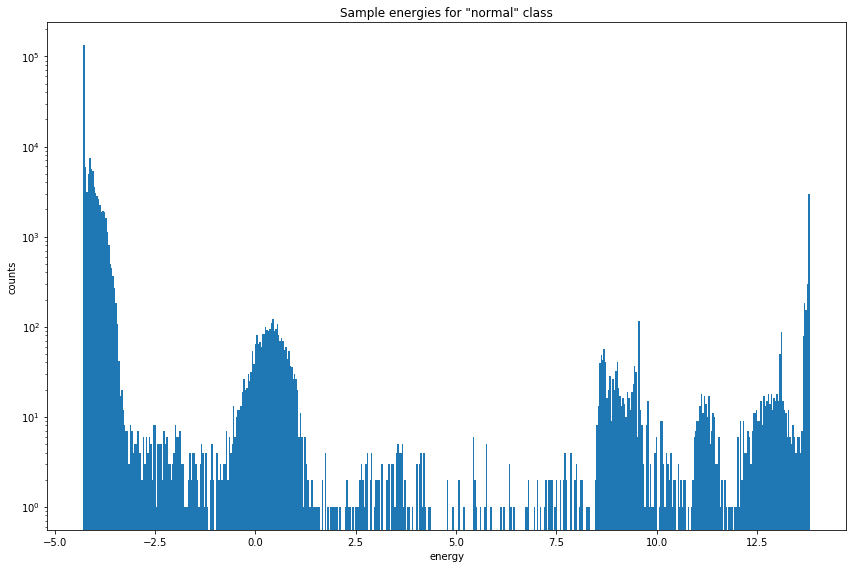

In [27]:
plt.hist(energies_normal, bins=hist_bins, log=True)

plt.title("Sample energies for \"normal\" class")
plt.xlabel("energy")
plt.ylabel("counts")
plt.tight_layout()

filename = timestamp + "-normalHist_bins{}.png".format(hist_bins)
plt.savefig(filename)

- Energies from anomaly class

In [28]:
energies_anomaly = eval_net.predict(anomaly_data, batch_size=1, verbose=1)  

48645/48645 [==============================] - 47s 976us/step


In [29]:
energies_anomaly

array([13.815511, 13.815511, 13.815511, ..., 13.815457, 13.815511,
       13.815511], dtype=float32)

In [30]:
energies_anomaly.min()

13.807362

In [31]:
energies_anomaly.max()

13.815511

In [32]:
plt.hist?

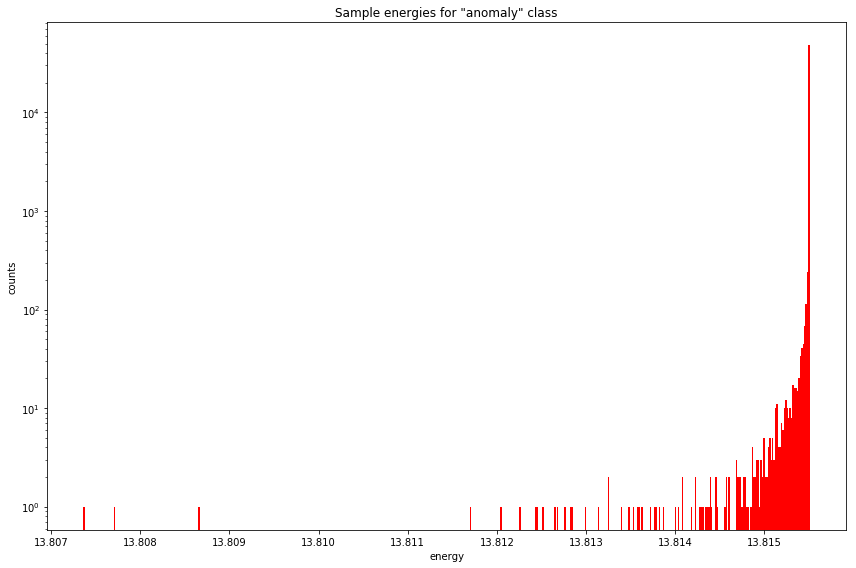

In [33]:
plt.hist(energies_anomaly, bins=hist_bins, color="red", log=True)

plt.title("Sample energies for \"anomaly\" class")
plt.xlabel("energy")
plt.ylabel("counts")
plt.tight_layout()

filename = timestamp + "-anomalyHist_bins{}.png".format(hist_bins)
plt.savefig(filename)

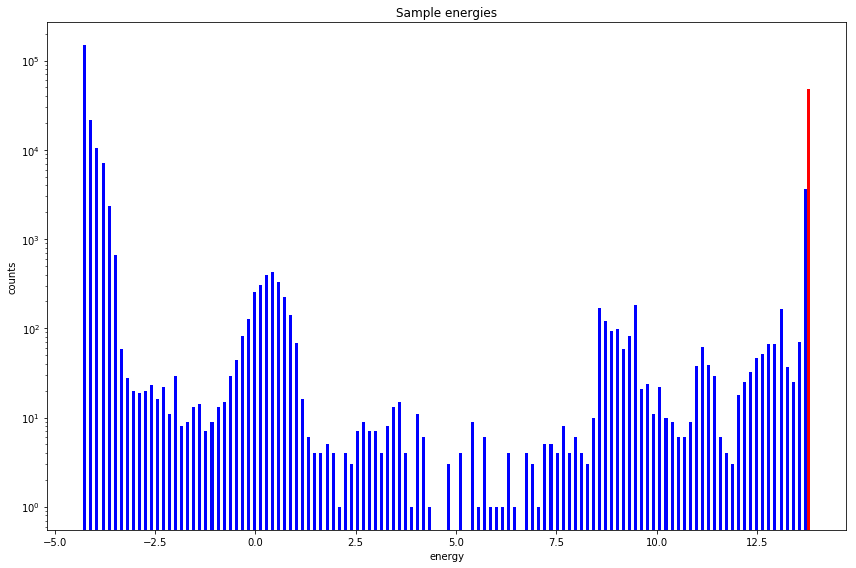

In [34]:
hist_bins = 120

plt.hist((energies_normal, energies_anomaly), 
         bins=hist_bins, 
         color=["blue", "red"], 
         histtype="bar", 
         label=["normal", "anomaly"], 
         rwidth=1.0,
         stacked=False,
         log=True)

plt.title("Sample energies")
plt.xlabel("energy")
plt.ylabel("counts")
plt.tight_layout()

filename = timestamp + "-allHist_bins{}.png".format(hist_bins)
plt.savefig(filename)


### Find the threshold for classifying as anomaly: "top %20 of highest energy"

In [35]:
energies_all = np.concatenate((energies_normal, energies_anomaly), axis=0)

In [36]:
energies_all.shape

(247011,)

- Sort calculated energies descending

In [37]:
sorted_energies = np.sort(energies_all)[::-1]

In [38]:
sorted_energies

array([13.815511, 13.815511, 13.815511, ..., -4.282052, -4.282052,
       -4.282052], dtype=float32)

- Top %20 percent is the first %20 part of it

In [39]:
threshold_index = int(np.floor(len(sorted_energies) * 0.2))

In [40]:
sorted_energies[:threshold_index]

array([13.815511, 13.815511, 13.815511, ..., 13.815504, 13.815504,
       13.815504], dtype=float32)

In [41]:
threshold = sorted_energies[threshold_index]

- Below this threshold, samples are classified as normal

In [42]:
threshold

13.815504

### Calculate metrics

- "Anomaly class is positive" (from paper)

|                   | anomaly | normal |   |   |
|-------------------|---------|--------|---|---|
| predicted anomaly | TP      | FP     |   |   |
| predicted normal  | FN      | TN     |   |   |
|                   |         |        |   |   |

In [43]:
tp = len(energies_anomaly[energies_anomaly > threshold])
fp = len(energies_normal[energies_normal > threshold])

tn = len(energies_normal[energies_normal < threshold])
fn = len(energies_anomaly[energies_anomaly < threshold])

In [44]:
precision = tp / (tp + fp)

In [45]:
precision

0.9600421675755672

In [46]:
recall = tp / (tp + fn)

In [47]:
recall

0.9748847167325428

In [48]:
f1 = 2*tp / (2*tp + fp + fn)

In [49]:
f1

0.967406514611401